# Autocorrelation and Decorrelation Scale Testing  

**Purpose**: Code for testing the Autocorrelation and decorrelation scale functions on fake data

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline


Import python libraries


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# Set path to access python functions
sys.path.append('/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/tools/')

#--- Luke's Python Functions ---# 
#from autocorr import compute_decor_scale, compute_autocorr

In [3]:
def compute_autocorr(data, x, lag, bias, norm = 0):

    """
    coef_pos, coef_neg, cov_pos, cov_neg = compute_autocorr(data, x, lag, task, bias, norm)

    Function for computing the autocovariance and autocorrelation 
    functions for positive and negative lag.
    
        Parameters
        ----------
        data : array
            Time or spatial series of data. This data must be preprocessed in the following ways:
            1) Detrend to remove any signal that is undesirable in the autocovariance function.
            2) Missing data gaps are filled with NaN values to ensure a continuous time series.
            3) Flagged data should be replaced with NaN values.
            
        lag : int
            The desired number of lags for computing the correlation. The specified amount of lags is dependent
            on the length of the time series. You want to set the amount of lags to a value where the 
            correlation coefficent is for the proper amount of iterations along to fixed time series.
            Ex: lag_dt = len(data) (compute correlation coefficient at lag decreasing by one measurement at a time).
            
        bias : str
            Specifies whether the covariance is biased or unbiased. The unbiased estimate is normalized by
            1/n-m whereas the biased estimate is normalized by 1/n where n = total number of data points in time
            series and m is the lag time from 0 lag. Furthermore, specifies whether the correlation coefficent is biased 
            or unbaised using the same normalizations in numerator (unbiased (normalized by 1/n-m) or biased
            (normalized by 1/n)) and the normalization 1/n for both cases in the demominator. 
            Options: 'biased' or 'unbiased'.

        norm : int
            Specifies which lagged covariance you want to normalize the autocovariance function by. The normal convention
            is to normalize it by the variance of the data record (the zeroth lag). However in the case where the noise in the
            measurements is causing a large drop in the autocorrelation from the zeroth lag to the first lag (introducing 
            a decorrelation signal different from the decorrelation from the natural variability of the system), normalizing the
            autocovariance function by the first lag will provide a more accurate decorrelation scale. Options includes 0 or 1 
            corresponds to the zero and first lag respectively. Default value: norm = 0. 
            
        Returns
        -------
        coef_pos : array
            Positive lag autocorrelation function.
            
        coef_neg : array
            Negative lag autocorrelation function.
            
        cov_pos : array
            Positive lag autocovariance function.
            
        cov_neg : array
            Negative lag autocovariance function.

        x_ref_pos : array
            Lag variable for positive lag autocorrelation or autocovariance functions. 

        x_ref_neg : array 
            Lag variable for positive lag autocorrelation or autocovariance functions. 

        Libraries necessary to run function
        -----------------------------------
        import numpy as np 

    """

    # Import libraries 
    import numpy as np

    # Choose interval length n which the correlation coefficient will be computed (Counting and discouting masked elements)
    N = len(data)
    N_eff = np.sum(~data.mask)

    # Initialize autocovariance and autocorrelation arrays
    R         = np.zeros(lag)   # Autocovariance
    rho       = np.zeros(lag)   # Autocorrelation 
    c_pairs_m  = np.zeros(lag)
    c_pairs_nm = np.zeros(lag)

    # Set the normalization factor for the autocorrelation 

    # Normalize by the zeroth lag 
    if norm == 0:

            # Set zero lagged data segments
            running = data[0:N]
            fix = data[:N-0]

            # Remove mean from each segment before computing covariance and correlation
            fix -= np.ma.mean(data)
            running -= np.ma.mean(data)

            # Compute the normalization
            Rnorm = (1/N_eff) * np.ma.dot(fix,running) #np.sum(data * np.conj(data))

    #--- Note ---# 
    # The normalization is the same for the biased, unbiased, and unbiased estimates when normalizing with the zeroth lag
    #  because the factors in front of the inner product are equivalent: 
    # 
    #       1/n_eff = (1 / n_eff) * (n / N) =  1/N_eff
    # 
    # This is because n_eff = N_eff and n = N at tau = 0. Recall that: 
    # 
    #                    n = N - k,
    # 
    # _eff denotes that the quantity excludes masked elements, and upper case N denotes that length of the full record
    # while lower case n denotes the length of the lagged record. 
    
    # Normalize by the first lag 
    elif norm == 1: 

        # Set lagged data segments
        running = data[1:N]
        fix = data[:N-1]

        # Remove mean from each segment before computing covariance and correlation
        fix -= np.ma.mean(data)
        running -= np.ma.mean(data)

        # Compute number of data pairs discounting pairs with masked vaules
        combined_mask = np.logical_or(fix.mask, running.mask)
        n_eff = np.sum(~combined_mask)
        n = len(running)
        
        #--- Unbiased ---# 
        if bias == 'unbiased':
            Rnorm = (1/n_eff) * np.ma.dot(fix,running) # np.sum(data[1:N] * np.conj(data[:N-1]))

        if bias == 'unbiased_tapered':
            Rnorm = (1/n_eff) * (n / N) * np.ma.dot(fix,running) # np.sum(data[1:N] * np.conj(data[:N-1]))

        #--- Biased ---# 
        if bias == 'biased': 
            Rnorm = (1/N_eff) * np.ma.dot(fix,running) # np.sum(data[1:N] * np.conj(data[:N-1]))

    # Loop through each lag interval to compute the correlation and covariance    
    for k in range(lag):

        # Set lagged data segments
        running = data[k:N]
        fix = data[:N-k]
        
        # Remove mean from each segment before computing covariance and correlation
        fix -= np.ma.mean(data)
        running -= np.ma.mean(data)

        # Compute the correlation coefficient terms at lag k
        inner_product = np.ma.dot(fix, running)

        # Compute the number of data pairs counting pairs with masked values
        n = len(running)  # Equivalent to N - k
        c_pairs_m[k] = n

        # Compute number of data pairs NOT counting pairs with masked vaules
        combined_mask = np.logical_or(fix.mask, running.mask)
        n_eff = np.sum(~combined_mask)
        c_pairs_nm[k] = n_eff
        
        # Compute autocorrelation and autocovariance function at lag k

        #--- Unbiased ---# 
        if bias == 'unbiased':
            R[k] = (1 / n_eff) * inner_product
            rho[k] = R[k] / Rnorm

        #--- Unbiased Tapered (Triangular taper) ---# 
        if bias == 'unbiased_tapered':
            R[k] = (1 / n_eff) * (n / N) * inner_product
            rho[k] = R[k] / Rnorm

        #--- Biased ---# 
        elif bias == 'biased':
            R[k] = (1 / N_eff) * inner_product
            rho[k] = R[k] / Rnorm
    
    # Combine positive and negative lag autocorrelation and autocovariance and set the lag vector
    if norm == 0:

        #--- Lag ---#  
        x_ref_pos = x - x[0]
        x_ref_neg = -1 * np.flip(x_ref_pos)[:-1]

        #--- Autocovariance ---# 
        R_pos = R
        R_neg = np.flip(R)[:-1]

        #--- Autocorrelation ---# 
        rho_pos = rho
        rho_neg = np.flip(rho)[:-1]

    elif norm == 1:

        #--- Lag ---#  
        x_ref_pos = x - x[0]
        x_ref_neg = -1 * np.flip(x_ref_pos)[:-1]

        #--- Autocovariance ---# 
        R_pos = R
        R_neg = np.flip(R)[:-1]

        #--- Autocorrelation ---# 
        rho_pos = np.insert(rho[1:], 0, 1) # Set zero lag to unity 
        rho_neg = np.flip(rho)[:-1]
    
    return rho_pos, rho_neg, R_pos, R_neg, x_ref_pos, x_ref_neg #, c_pairs_m, c_pairs_nm (ignoring this output)

In [4]:
#--- Decorrelation Scale Analysis ---%
def compute_decor_scale(autocorr,x_ref,dx,bias,norm):

    """
    Computes the decorrelation scale as an intergral time scale from the positively lag autocorrelation function.  

    Parameters
    ----------
    autocorr : array
            Positive lag autocorrelation function. 
    x_ref : array 
            Lag time or distance independent variable. 
    dx : float 
            The distance between data points in physical space. 
    bias : str
            Specifies whether the covariance is biased or unbiased. The unbiased estimate is normalized by
            1/n-m whereas the biased estimate is normalized by 1/n where n = total number of data points in time
            series and m is the lag time from 0 lag. Options: 'biased' or 'unbiased'.
    norm : int
            Specifies which lagged covariance you want to normalize the autocovariance function by. The normal convention
            is to normalize it by the variance of the data record (the zeroth lag). However in the case where the noise in the
            measurements is causing a large drop in the autocorrelation from the zeroth lag to the first lag (introducing 
            a decorrelation signal different from the decorrelation from the natural variability of the system), normalizing the
            autocovariance function by the first lag will provide a more accurate decorrelation scale. Options includes 0 or 1 
            corresponds to the zero and first lag respectively. Default value: norm = 0. 
    

    Returns
    -------
    scale : float 
        The integral time scale estimate of the decorrelation scale. 

    Libraries necessary to run function
    -----------------------------------
    import numpy as np 
    from scipy.integrate import trapezoid

    """

    # Import libraries 
    import numpy as np
    from scipy.integrate import trapezoid
    
    # Normalize by the zeroth lag 
    if norm == 0: 

        # Set the positive and negative lagged autocovariance functions
        autocorr_pos = autocorr
        autocorr_neg = np.flip(autocorr)[:-1]

        # Set the positive and negative lag variable
        x_ref_pos = x_ref
        x_ref_neg = -1 * np.flip(x_ref)[:-1]

        # Set the length of data series and data interval
        N = len(autocorr_pos)      # length of one-sided autocorrelation function (and number of samples in data record)
        R = N * dx                 # length of the data series (units of time or space)

        # Initialize scale_N variable
        scale_N = np.zeros(N)

        # Loop through lags 
        for i in range(N):

                # Index autocorrelation function 

                #--- Zeroth lag ---# 
                if i == 0:

                        # Set interal of the autocorrelation function to zero (intergration range vanishes)
                        iscale = 0  

                #--- Higher Order lag ---#     
                else:

                        # Index the autocorrelation function and combine the negative and positive lagged autocorrelation functions 
                        coef = np.concatenate((autocorr_neg[N-i-1:], autocorr_pos[:i+1]))
                        x    = np.concatenate((x_ref_neg[N-i-1:], x_ref_pos[:i+1]))

                        # Compute time or spatial lag
                        r = i * dx

                        # Compute integral of autocorrelation function (with triangular filter weighting lower lags for unbiased estimator)
                        if bias == 'unbiased':
                                iscale = trapezoid((1 - (r / R)) * coef, x, dx=dx)
                        elif bias == 'biased':
                                iscale = trapezoid(coef, x, dx=dx)

                # Save the ith scaling factor=
                scale_N[i] = iscale

        # Find the maximum decorrelation time scale (conservative estimate)
        scale = np.nanmax(scale_N)

    #--- Normalize by the first lag ---#
    elif norm == 1: 

        # Set the positive lagged autocovariance functions
        autocorr_pos = autocorr

        # Set the length of data series and data interval
        N = len(autocorr_pos)  # length of one-sided autocorrelation function
        R = N * dx             # length of the data series

        # Initialize scale_N variable
        scale_N = np.zeros(N)

        # Loop through lags 
        for i in range(N):

                # Index autocorrelation function 

                #--- Zeroth and first lag ---# 
                if i == 0:

                        # Set interal of the autocorrelation function to zero (intergration range vanishes)
                        iscale = 0  

                #--- Higher Order lag ---#     
                else:

                        # Index the autocorrelation function and combine the negative and positive lagged autocorrelation functions 
                        autocor_pos_lag = autocorr_pos[:i+1]

                        # Index the autocorrelation function 
                        x_ref_pos_lag = x_ref[:i+1]

                        # Compute spatial lag
                        r = i * dx

                        # Compute integral of autocorrelation function (using the symmetry across the y-axis)
                        if bias == 'unbiased': 
                               iscale_pos = trapezoid((1 - (r / R)) * autocor_pos_lag, x_ref_pos_lag, dx=dx) 
                        elif bias == 'biased': 
                               iscale_pos = trapezoid(autocor_pos_lag, x_ref_pos_lag, dx=dx) 
                        iscale = 2*iscale_pos

                # Save the ith scaling factor
                scale_N[i] = iscale


        # Find the maximum decorrelation time scale (conservative estimate)
        scale = np.nanmax(scale_N)

    return scale 

Generate a single step function 

In [ ]:
# Define the quick inline step function 
step_function = lambda x: np.where(x < 0, -1, 1).astype(np.float64)

# Set independent variable 
L_tot = 100                 # Extent of signal, units: km
dx = 5                    # Time step intervals, units: seconds
N = int(np.round(L_tot/dx)) # Number of samples in the the record 
x = np.linspace(-L_tot/2,L_tot/2,N)

# Generate normally distributed noise
mean = 0       
std_dev = 0.1
noise = np.random.normal(mean, std_dev, size=x.shape)

# Generat fake data 
data = step_function(x) + noise 

# Convert the fake data to a masked array 
data_m = np.ma.array(data, mask=np.zeros(len(x)))

# Plot the time series 
plt.plot(x,data_m,'b.-')
plt.xlabel('Distance (km)')
plt.ylabel('Sea Surface Height (m)')
plt.show()

In [ ]:
# Set parameters
lag = len(data_m)
estimator = 'biased'
autocor_data0, _, autocov_data0, _, x_ref0, _ = compute_autocorr(data_m, x, lag, estimator, 0)
autocor_data1, _, autocov_data1, _, x_ref1, _ = compute_autocorr(data_m, x, lag, estimator, 1)

# Compute the decorrelation scale
scale0 = compute_decor_scale(autocor_data0,x_ref0,dx,estimator,0)
scale1 = compute_decor_scale(autocor_data1,x_ref1,dx,estimator,1)

# Plot the autocorrelation function 
plt.plot(x_ref0,autocor_data0,'b.-')
if std_dev != 0: 
    plt.plot(x_ref1,autocor_data1,'g.-')
#plt.plot(x_ref0,autocov_data0,'b.-')
plt.xlabel(r'Distance Scale $\delta$ (km)')
plt.ylabel(r'$\rho(\delta)$')
plt.grid()
plt.show()

if std_dev == 0:
    print('Decorrelation scale: ' + str(scale0) + ' km and number of independent data points: ' + str(scale0/dx))
else: 
    print('Decorrelation scale (noise NOT removed): ' + str(scale0) + ' km and number of independent data points: ' + str(scale0/dx))
    print('Decorrelation scale (noise removed): ' + str(scale1) + ' km and number of independent data points: ' + str(scale1/dx))

Generate a series of step functions

In [ ]:
# Number of steps
num_steps = 100

# Generate random values between -1 and 1 for each step
step_values = np.random.uniform(-1, 1, num_steps)

# Repeat each value 10 times to create the step pattern
step_series = np.repeat(step_values, 10)

# Set independent variable 
L_tot = 100                         # Extent of signal, units: km
N = len(step_series)                # Number of samples in the the record 
dx = L_tot/N                              # Length scale intervals, units: km
x = np.linspace(-L_tot/2,L_tot/2,N)

# Generate normally distributed noise
mean = 0       
std_dev = 0
noise = np.random.normal(mean, std_dev, size=x.shape)

# Generat fake data 
data = step_series + noise 

# Convert the fake data to a masked array 
data_m = np.ma.array(data, mask=np.zeros(len(x)))

# Plot the time series 
plt.plot(x,data_m,'b.-')
plt.xlabel('Distance (km)')
plt.ylabel('Sea Surface Height (m)')
plt.show()

In [ ]:
# Set parameters
lag = len(data_m)
estimator = 'biased'
autocor_data0, _, autocov_data0, _, x_ref0, _ = compute_autocorr(data_m, x, lag, estimator, 0)
autocor_data1, _, autocov_data1, _, x_ref1, _ = compute_autocorr(data_m, x, lag, estimator, 1)

# Compute the decorrelation scale
scale0 = compute_decor_scale(autocor_data0,x_ref0,dx,estimator,0)
scale1 = compute_decor_scale(autocor_data1,x_ref1,dx,estimator,1)

# Plot the autocorrelation function 
plt.plot(x_ref0,autocor_data0,'b.-')
if std_dev != 0: 
    plt.plot(x_ref1,autocor_data1,'g.-')
#plt.plot(x_ref0,autocov_data0,'b.-')
plt.xlabel(r'Distance Scale $\delta$ (km)')
plt.ylabel(r'$\rho(\delta)$')
plt.grid()
plt.show()

if std_dev == 0:
    print('Decorrelation scale: ' + str(scale0) + ' km and number of independent data points: ' + str(scale0/dx))
else: 
    print('Decorrelation scale (noise NOT removed): ' + str(scale0) + ' km and number of independent data points: ' + str(scale0/dx))
    print('Decorrelation scale (noise removed): ' + str(scale1) + ' km and number of independent data points: ' + str(scale1/dx))

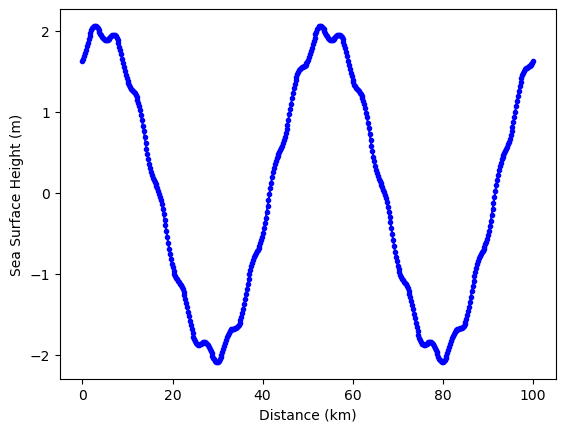

Variance: 2.0063 m^2


In [26]:
# Set signal parameters
A1 = 0.1;        # Amplitude of signal 1, units: meters
A2 = 2;      # Amplitude of signal 2, units: meters
L1 = 5;         # Wavelength of signal 1, units: km
L2 = 50;       # wavelength of signal 2, units: km
nu1 = 1/L1;    # Cyclical Frequency  
nu2 = 1/L2;    # Cyclical Frequency 
phi1 = 3*np.pi/2 # Phase shift of signal 1, units: radians
phi2 = np.pi/3 # Phase shift of signal 1, units: radians

# Set space parameters
L_tot = 100  # Duration of signal, units: seconds
dx = 0.2        # Time step intervals, units: seconds
N = int(np.round(L_tot/dx)) # Number of samples in the the record 

# Compute the space vector 
x = np.linspace(0,L_tot,N)

# Generate normally distributed noise
mean = 0       
std_dev = 0
noise = np.random.normal(mean, std_dev, size=x.shape)

# Compute the fake data with noise
signal = A1*np.sin(2*np.pi*nu1 * x + phi1) + A2*np.sin(2*np.pi*nu2 * x + phi2)
data = signal + noise 

# Convert the fake data to a masked array 
data_m = np.ma.array(data, mask=np.zeros(len(x)))

# Plot the time series 
plt.plot(x,data_m,'b.-')
plt.xlabel('Distance (km)')
plt.ylabel('Sea Surface Height (m)')
plt.show()

# Compute the variance in the time series 
N = len(data_m)
var = ((1 / N) * np.ma.sum((data_m - np.ma.mean(data_m))**2))
print('Variance: ' + str(np.round(var,4)) + ' m^2')


Compute the autocorrelation function 

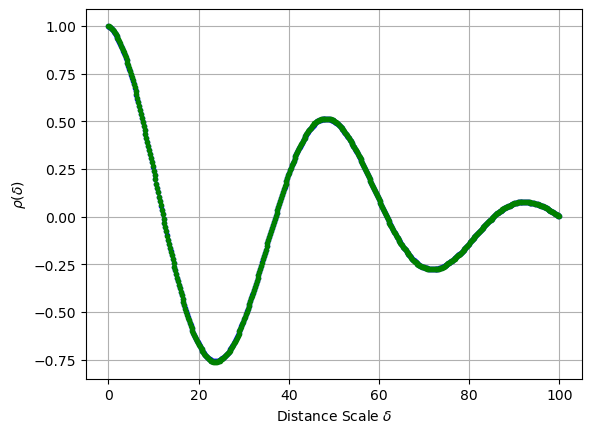

Wavelength of the signal: 5
Decorrelation scale (noise removed): 14.596014608552329 km and number of independent data points: 72.98007304276165


In [27]:
# Set parameters
lag = len(data_m)
estimator = 'biased'
autocor_data0, _, autocov_data0, _, x_ref0, _ = compute_autocorr(data_m, x, lag, estimator, 0)
autocor_data1, _, autocov_data1, _, x_ref1, _ = compute_autocorr(data_m, x, lag, estimator, 1)

# Compute the decorrelation scale
scale0 = compute_decor_scale(autocor_data0,x_ref0,dx,estimator,0)
scale1 = compute_decor_scale(autocor_data1,x_ref1,dx,estimator,1)

# Plot the autocorrelation function 
plt.plot(x_ref0,autocor_data0,'b.-')
plt.plot(x_ref1,autocor_data1,'g.-')
# plt.plot(x_ref0,autocov_data0,'b.-')
plt.xlabel(r'Distance Scale $\delta$')
plt.ylabel(r'$\rho(\delta)$')
plt.grid()
plt.show()

print('Wavelength of the signal: ' + str(L1))
#print('Decorrelation scale (noise NOT removed): ' + str(scale0) + ' km and number of independent data points: ' + str(scale0/dx))
print('Decorrelation scale (noise removed): ' + str(scale1) + ' km and number of independent data points: ' + str(scale1/dx))

In [28]:
scale0*np.pi

45.71731534905443

Illustration of the triangular filter for the decorrelation scale calculation 

In [ ]:
R = 100
dr = 1
r = np.arange(0,R,dr)
f_r = 1-(r/R)

plt.plot(r,f_r,'k.-')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(scale_N_tri,'k.-')
plt.plot(scale_N,'b.-')
plt.grid()
plt.show()

print('Prescribed standard deviation of noise: ' + str(std_dev)) 
print('Computed standard deviation of signal: ' + str(np.std(signal,ddof=1)))
print('Computed standard deviation of noise: ' + str(np.std(noise,ddof=1)))
print('Standard deviation of noise from autocovariance function: ' + str(np.sqrt(autocov_data0[0]-autocov_data0[1])))
print('')
print('Computed variance of signal: ' + str(np.var(signal,ddof=1)))
print('Computed variance of noise: ' + str(np.var(noise,ddof=1)))
print('Computed variance of data record: ' + str(np.var(data,ddof=1)))
print('Variance of signal and noise: ' + str(autocov_data0[0]))